# introduction

In [1]:
from datetime import timedelta
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from lib import y_smooth, go_chart, distribution, chart_distribution

import colorlover as cl
from IPython.display import HTML
colors = cl.scales['11']['div']['RdYlBu']
colors = colors[:5] + ['rgb(183,188,143)','rgb(143,188,143)'] + colors[8:]
HTML(cl.to_html(colors))

In [2]:
xls = pd.ExcelFile("./webscraper/coronav.xls")
cases = xls.parse('cases')
deaths = xls.parse('deaths')
recovery = xls.parse('recovery')

cases['date'] = pd.to_datetime(cases['date'])
deaths['date'] = pd.to_datetime(cases['date'])
recovery['date'] = pd.to_datetime(recovery['date'])

cases = cases.set_index('date')
deaths = deaths.set_index('date')
recovery = recovery.set_index('date')

try:
    del cases['Unnamed: 0']
    del deaths['Unnamed: 0']
    del recovery['Unnamed: 0']
except:
    print ('no Unnamed: 0')

# preliminary

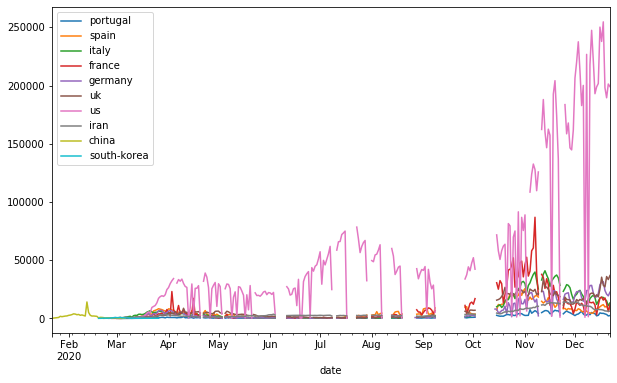

In [3]:
#cases per day
cases.plot(figsize=(10,6))

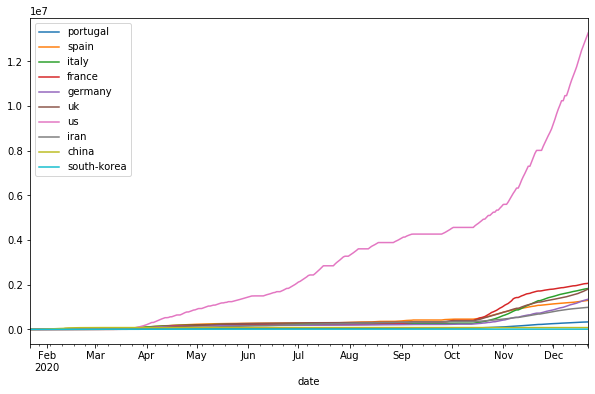

In [4]:
#total cases
cases.fillna(0).cumsum().plot(figsize=(10,6))

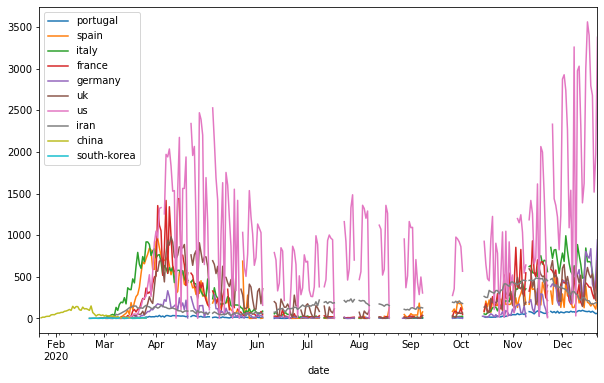

In [5]:
#deaths per day
deaths.plot(figsize=(10,6))

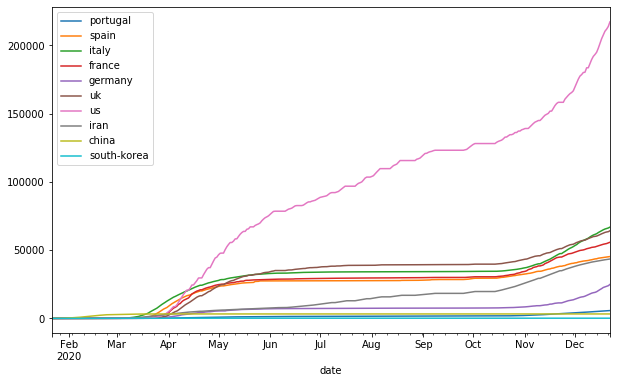

In [6]:
#total deaths
deaths.fillna(0).cumsum().plot(figsize=(10,6))

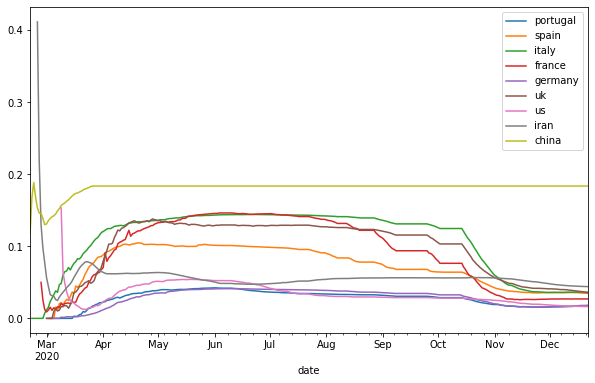

In [7]:
#deaths per cases per day
deaths.iloc[30:,:-1].fillna(0).cumsum().divide(cases.iloc[30:,:-1].fillna(0).cumsum()).plot(figsize=(10,6))

# daily by country

In [8]:
#cases

for col in cases.columns:
        
    mindate = min(cases.loc[cases[col].notnull()].index)-timedelta(days=1)
    y = cases.loc[cases[col].index>=mindate,col].fillna(0)
    x = np.arange(len(y))
    
    xdata, ydata, x_axis, y_axis, c = distribution(x,y)
    chart_distribution(y,ydata,col,ylabel='daily cases')

In [9]:
#deaths

for col in deaths.columns:
        
    mindate = min(deaths.loc[deaths[col].notnull()].index)-timedelta(days=1)
    y = deaths.loc[deaths[col].index>=mindate,col].fillna(0)
    x = np.arange(len(y))
    
    xdata, ydata, x_axis, y_axis, c = distribution(x,y)
    chart_distribution(y,ydata,col,ylabel='daily deaths')

In [10]:
#cases/deaths

for col in deaths.columns:
        
    mindate = min(deaths.loc[deaths[col].notnull()].index)-timedelta(days=1)
    y = cases[col]/deaths[col]
    y = y.loc[y.index>=mindate].fillna(0)
    x = np.arange(len(y))
    
    xdata, ydata, x_axis, y_axis, c = distribution(x,y)
    chart_distribution(y,ydata,col,ylabel='cases/daily')

# all countries

In [11]:
#cases per day
go_chart(cases,title='daily cases',y_savgol_filter=savgol_filter)

In [12]:
#deaths per day
go_chart(deaths,title='daily deaths',y_savgol_filter=savgol_filter)

In [13]:
#total cases
go_chart(cases.cumsum(),title='total cases')

In [14]:
#total deaths
go_chart(deaths.cumsum(),title='total deaths')

# italy

In [15]:
c = 'italy'


##### chart
fig = go.Figure(data=[
    go.Scatter(
        x=cases[c].index,
        y=savgol_filter(cases[c].fillna(0),3,1),
        name='cases',
        line=dict(color=colors[1],width=4)
    ),
    go.Scatter(
        x=deaths[c].index,
        y=savgol_filter((deaths[c]+recovery[c]).fillna(0),3,1),
        name='deaths+recovery',
        line=dict(color=colors[-2],width=4),
        yaxis="y2"
    )    
])

fig.update_layout(
    title=c,
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1
    ),
)

fig.show()

In [16]:
c = 'italy'

##### chart
fig = go.Figure(data=[
    go.Scatter(
        x=cases[c].index,
        y=savgol_filter(cases[c].fillna(0),3,1),
        name='cases',
        line=dict(color=colors[1],width=4)
    ),
    go.Scatter(
        x=deaths[c].index,
        y=savgol_filter(deaths[c].fillna(0),3,1),
        name='deaths',
        line=dict(color=colors[-2],width=4),
        yaxis="y2"
    )
])

fig.update_layout(
    title=c,
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1
    ),
)

fig.show()

In [17]:
c = 'italy'

##### chart
fig = go.Figure(data=[
    go.Scatter(
        x=cases[c].index,
        y=savgol_filter(cases[c].fillna(0),3,1),
        name='cases',
        line=dict(color=colors[1],width=4)
    ),
    go.Scatter(
        x=recovery[c].index,
        y=savgol_filter(recovery[c].fillna(0),3,1),
        name='recovery',
        line=dict(color=colors[-2],width=4),
        yaxis="y2"
    )
])

fig.update_layout(
    title=c,
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1
    ),
)

fig.show()

# trends

In [18]:
c = 'italy'

signal1 = cases.loc[cases[c].fillna(0)!=0,c].diff()
filtered1 = lowess(signal1.values, signal1.index, is_sorted=True, frac=1)

fig = go.Figure(data=[
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=signal1,
        name='diff',
        mode='lines+markers',
        line=dict(color=colors[-1],width=4)
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=filtered1[:,1],
        name='diff filtered',
        mode='lines',
        line=dict(color=colors[-3],width=4,dash='dash')
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=cases.loc[cases[c].fillna(0)!=0,c],
        mode='lines+markers',
        name='daily cases',
        line=dict(color=colors[2],width=4),
        yaxis="y2"
    )
])
   
fig.update_layout(
    title='%s - diff: today-yesterday'%c.upper(),
    yaxis=dict(
        color=colors[-2]
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1,
        color=colors[2],
    ),
)

fig.show()

In [19]:
c = 'italy'

signal1 = cases.loc[cases[c].fillna(0)!=0,c].divide(cases.loc[cases[c].fillna(0)!=0,c].shift())
filtered1 = lowess(signal1.values, signal1.index, is_sorted=True, frac=1)

fig = go.Figure(data=[
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=signal1,
        name='div',
        mode='lines+markers',
        line=dict(color=colors[-1],width=4)
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=filtered1[:,1],
        name='div filtered',
        mode='lines',
        line=dict(color=colors[-3],width=4,dash='dash')
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=cases.loc[cases[c].fillna(0)!=0,c],
        mode='lines+markers',
        name='daily cases',
        line=dict(color=colors[2],width=4),
        yaxis="y2"
    )
])
   
fig.update_layout(
    title='%s - today/yesterday'%c.upper(),
    yaxis=dict(
        color=colors[-2]
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1,
        color=colors[2],
    ),
)

fig.show()

In [20]:
c = 'germany'

signal1 = cases.loc[cases[c].fillna(0)!=0,c].divide(cases.loc[cases[c].fillna(0)!=0,c].shift())
filtered1 = lowess(signal1.values, signal1.index, is_sorted=True, frac=1)

fig = go.Figure(data=[
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=signal1,
        name='div',
        mode='lines+markers',
        line=dict(color=colors[-1],width=4)
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=filtered1[:,1],
        name='div filtered',
        mode='lines',
        line=dict(color=colors[-3],width=4,dash='dash')
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=cases.loc[cases[c].fillna(0)!=0,c],
        mode='lines+markers',
        name='daily cases',
        line=dict(color=colors[2],width=4),
        yaxis="y2"
    )
])
   
fig.update_layout(
    title='%s - today/yesterday'%c.upper(),
    yaxis=dict(
        color=colors[-2],
        range=[0,5]
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1,
        color=colors[2],
    ),
)

fig.show()

In [21]:
c = 'italy'

signal1 = cases.loc[cases[c].fillna(0)!=0,c].divide(
    cases.loc[cases[c].fillna(0)!=0,c].shift().cumsum().fillna(1))
filtered1 = lowess(signal1.values, signal1.index, is_sorted=True, frac=1)

fig = go.Figure(data=[
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index[3:],
        y=signal1[3:]*100,
        name='increment rate',
        mode='lines+markers',
        line=dict(color=colors[-2],width=4)
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index[3:],
        y=filtered1[:,1][3:]*100,
        name='increment rate filtered',
        mode='lines',
        line=dict(color=colors[-3],width=4,dash='dash')
    ),
    go.Scatter(
        x=cases.loc[cases[c].fillna(0)!=0,c].index,
        y=cases.loc[cases[c].fillna(0)!=0,c],
        mode='lines+markers',
        name='daily cases',
        line=dict(color=colors[2],width=4),
        yaxis="y2"
    )
])

fig.update_layout(
    title='%s - increment rate: (today-yesterday)/yesterday*100'%c.upper(),
    yaxis_title='[%]',
    yaxis=dict(
        color=colors[-2]
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="right",
        position=1,
        color=colors[2],
    ),
)

fig.show()

In [22]:
country = None
data_name = 'cases'


if data_name == 'cases':
    data = cases.copy()
else:
    data = deaths.copy()

if country:
    
    fig = go.Figure(data=[
        go.Scatter(
            x=data[country].cumsum().fillna(method='ffill').values[:],
            y=data[country].fillna(method='ffill').values[:],
            name=country,
            mode='lines+markers',
            line=dict(width=2),
            marker=dict(size=4),
            showlegend=False,
        )
    ]+[
        go.Scatter(
            x=data[country].cumsum().fillna(method='ffill').values[-1:],
            y=data[country].fillna(method='ffill').values[-1:],
            name=country,
            mode='markers',
            marker=dict(size=10,line=dict(width=2,color='Black')),
        )
    ])
    
else:
        
    fig = go.Figure(data=[
        go.Scatter(
            x=data[c].cumsum().fillna(method='ffill').values[:],
            y=data[c].fillna(method='ffill').values[:],
            name=c,
            mode='lines+markers',
            line=dict(color=colors[i],width=2),
            marker=dict(size=4),
            showlegend=False,
        )
        for i,c in enumerate([x for _,x in sorted(zip(
            data.fillna(method='ffill').iloc[-1,:],data.columns
        ))][::-1])
    ]+[
        go.Scatter(
            x=data[c].cumsum().fillna(method='ffill').values[-1:],
            y=data[c].fillna(method='ffill').values[-1:],
            name=c,
            mode='markers',
            marker=dict(color=colors[i],size=10,line=dict(width=2,color='Black')),
        )
        for i,c in enumerate([x for _,x in sorted(zip(
            data.fillna(method='ffill').iloc[-1,:],data.columns
        ))][::-1])
    ])

fig.add_trace(go.Scatter(
    x=[2, 15],
    y=[2000, 20000],
    mode='lines',
    line=dict(color='Black'),
    showlegend=False,
))
fig.add_trace(go.Scatter(
    x=[15, 30],
    y=[20000, 20000],
    mode='lines',
    line=dict(color='Black'),
    showlegend=False,
))
fig.add_trace(go.Scatter(
    x=[30, 32],
    y=[20000, 1000],
    mode='lines',
    line=dict(color='Black'),
    showlegend=False,
))

fig.update_layout(
    yaxis_title='daily %s'%data_name,
    xaxis_title='total %s'%data_name,
    xaxis_type="log", 
    yaxis_type="log", 
    annotations=[
        dict(
            x=.7,
            y=3.9,
            xref="x",
            yref="y",
            text="increasing",
            showarrow=False,
            textangle=-35,
            font=dict(
                family="sans serif",
                size=12,
                color="Black",
            )
        ),        
        dict(
            x=1.35,
            y=4.42,
            xref="x",
            yref="y",
            text="stationary",
            showarrow=False,
            font=dict(
                family="sans serif",
                size=12,
                color="Black",
            )
        ),
        dict(
            x=1.56,
            y=3.65,
            xref="x",
            yref="y",
            text="decreasing",
            textangle=87,
            showarrow=False,
            font=dict(
                family="sans serif",
                size=12,
                color="Black",
            )
        )
    ]
)
fig.update_yaxes(range=[0,5])
# fig.update_xaxes(range=[0,7])

fig.show()

In [23]:
data_name = 'cases'

if data_name == 'cases':
    data = cases.copy()
else:
    data = deaths.copy()
    
fig = go.Figure(data=[
    go.Scatter(
        x=data[c].cumsum().fillna(method='ffill').values[:],
        y=data[c].fillna(method='ffill').values[:],
        name=c,
        mode='lines+markers',
        line=dict(color=colors[i+i*2],width=2),
        marker=dict(size=4),
        showlegend=False,
    )
    for i,c in enumerate(['us','italy','china'])
]+[
    go.Scatter(
        x=data[c].cumsum().fillna(method='ffill').values[-1:],
        y=data[c].fillna(method='ffill').values[-1:],
        name=c,
        mode='markers',
        marker=dict(color=colors[i+i*2],size=10,line=dict(width=2,color='Black')),
    )
    for i,c in enumerate(['us','italy','china'])
])

fig.update_layout(
    yaxis_title='daily %s'%data_name,
    xaxis_title='total %s'%data_name,
    xaxis_type="log", 
    yaxis_type="log", 
)

fig.show()